# Определение перспективного тарифа для телеком компании

Необходимо предстоит сделать предварительный анализ тарифов телеком компании на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Общая информация о данных

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st

В нашем распоряжении 5 файлов со следующими данными:
1. *calls* - информация о длительности звонков пользователей;
2. *internet* - информация об использованных мегабатайх;
3. *messages* - информация об отправленных смс;
4. *tariffs* - описание тарифов оператора;
5. *users* - информация о самих пользователях.

In [6]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица calls (информация о звонках):
- id — уникальный номер звонка;
- call_date — дата звонка;
- duration — длительность звонка в минутах;
- user_id — идентификатор пользователя, сделавшего звонок.

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии;
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
- session_date — дата интернет-сессии;
- user_id — идентификатор пользователя.

В выгруженном файле видим неизвестный нам столбец "Unnamed: 0", который, похоже, дублирует индексы. Удалим столбец, т.к. для исследования он нам не потребуется. Однако, необходимо уточнить у коллег, по какой причине этот столбец появился в файле.

In [11]:
internet = internet.drop('Unnamed: 0', axis=1)

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [13]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения;
- message_date — дата сообщения;
- user_id — идентификатор пользователя, отправившего сообщение.

In [15]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа;
- rub_monthly_fee — ежемесячная абонентская плата в рублях;
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
- messages_included — количество сообщений в месяц, включённых в абонентскую плату;
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

In [16]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя;
- first_name — имя пользователя;
- last_name — фамилия пользователя;
- age — возраст пользователя (годы);
- reg_date — дата подключения тарифа (день, месяц, год);
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- city — город проживания пользователя;
- tariff — название тарифного плана.

## Предобработка данных

Приведем данные к нужным типам. Попробуем выявить ошибки в данных и исправить их.
При просмотре общей информации о датасетах пропуски в них обнаружены не были. Однако есть столбцы в формате object, содержащие в себе информацию о какой-либо дате. Переведем эти данные к нужному формату.

In [18]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y/%m/%d')
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y/%m/%d')
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y/%m/%d')
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y/%m/%d')
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y/%m/%d')

В датасете users содержится 2 столбцами с датами: дата регистрации и дата прекращения пользования тарифом. Убдимся, что ни один из пользователей не прекратил пользоваться услугами до регистрации.

In [19]:
users.query('churn_date < reg_date')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


С датами регистрации успешно разобрались, ошибок не обнаружено.
Убедимся, что в наших датафреймах отсутствуют полные дубли строк.

In [20]:
users[users.duplicated()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [21]:
calls[calls.duplicated()]

,id,call_date,duration,user_id


In [22]:
messages[messages.duplicated()]

,id,message_date,user_id


In [23]:
internet[internet.duplicated()]

,id,mb_used,session_date,user_id


Каждая строка в каждом датафрейме уникальна. Перейдем к ошибках в данных о звонках и интернет сессиях.
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Поэтому нам нужно сделать 2 преобразования:
1. Увеличим нулевые значения звонков на 1.
2. Округлим значения в обоих столбцах до целого в большую сторону.

In [24]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

In [25]:
calls.loc[calls.duration == 0, 'duration'] += 1

In [26]:
calls['duration'].describe()

count    202607.000000
mean          6.951404
std           5.626759
min           0.010000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Среднее значение длительности звонок после преобразования увеличилось на 0,2 минуты. При этом 75% выборки по-прежнему содержатся в интервале до 10,7 минут. Можно сказать, что наши преобразования не сильно повлияли на выборку.

Округлим наши данные в большую сторону до целого числа.

In [28]:
calls['duration'] = calls['duration'].round()

In [29]:
internet['mb_used'] = internet['mb_used'].round()

<font color=brown>Так, обещали округление в большую сторону, а сделеали обычное. Для округления вверх есть замечательный метод `math.ceil()`.

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Для проведения вычислений нам нужно собрать все данные в один общий датафрейм. 
Так как мы будем исследовать результаты по месяцам, добавим соответствующий столбец с месяцем звонка, интернет-сессии, сообщений и регистрации в каждый датафрейм.

In [30]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
users['month'] = pd.DatetimeIndex(users['reg_date']).month

Сгруппируем данные по трем пунктам:
1. по длительности звонков каждого пользователя в месяц;
2. по расходам интернет-трафика каждого пользователя в месяц;
3. по количеству сообщений, отправленных каждым пользователем в месяц.

In [31]:
calls_1 = calls.groupby(['user_id', 'month'])['duration'].agg(['sum']).reset_index()
calls_1.head()

,user_id,month,sum
0,1000,5,154.0
1,1000,6,174.0
2,1000,7,325.0
3,1000,8,401.0
4,1000,9,451.0


In [32]:
internet_1 = internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum']).reset_index()
internet_1.head()

,user_id,month,sum
0,1000,5,2253.0
1,1000,6,23232.0
2,1000,7,14004.0
3,1000,8,14054.0
4,1000,9,14569.0


In [33]:
messages_1 = messages.groupby(['user_id', 'month'])['id'].agg(['count']).reset_index()
messages_1.head()

,user_id,month,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Объединим полученные таблицы с информацией о пользователях, чтобы увидеть, какими услугами и в каком размере пользовался каждый абонент в месяц.

In [34]:
df1 = calls_1.merge(internet_1, on=['user_id', 'month'], how='outer')
df1.head()

,user_id,month,sum_x,sum_y
0,1000,5,154.0,2253.0
1,1000,6,174.0,23232.0
2,1000,7,325.0,14004.0
3,1000,8,401.0,14054.0
4,1000,9,451.0,14569.0


In [35]:
df2 = df1.merge(messages_1, on=['user_id', 'month'], how='outer')
df2.head()

,user_id,month,sum_x,sum_y,count
0,1000,5,154.0,2253.0,22.0
1,1000,6,174.0,23232.0,60.0
2,1000,7,325.0,14004.0,75.0
3,1000,8,401.0,14054.0,81.0
4,1000,9,451.0,14569.0,57.0


In [36]:
df3 = df2.merge(users, on=['user_id'], how='outer')
df3.head()

,user_id,month_x,sum_x,sum_y,count,age,churn_date,city,first_name,last_name,reg_date,tariff,month_y
0,1000,5.0,154.0,2253.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5


Переименуем столбцы следующим образом:
- month - месяц использования тарифа;
- minutes - общая длительность звонков, совершенных пользователем в месяц;
- mb - общий объем потраченного интернет-трафика в месяца;
- messages - количество отправленных сообщений в месяц;
- reg-month - месяц регистрации пользователя.

In [37]:
df3 = df3.rename(columns={"month_x": "month",
                          "sum_x": "minutes", "sum_y": "mb", "count": "messages", "month_y": "reg_month"})

In [38]:
df3.head(20)

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,5.0,154.0,2253.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
5,1000,10.0,341.0,14701.0,73.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
6,1000,11.0,324.0,14756.0,58.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
7,1000,12.0,322.0,9818.0,70.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
8,1001,11.0,424.0,18428.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11
9,1001,12.0,409.0,14040.0,NaN,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11


In [39]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3216 non-null   int64         
 1   month       3214 non-null   float64       
 2   minutes     3174 non-null   float64       
 3   mb          3203 non-null   float64       
 4   messages    2717 non-null   float64       
 5   age         3216 non-null   int64         
 6   churn_date  189 non-null    datetime64[ns]
 7   city        3216 non-null   object        
 8   first_name  3216 non-null   object        
 9   last_name   3216 non-null   object        
 10  reg_date    3216 non-null   datetime64[ns]
 11  tariff      3216 non-null   object        
 12  reg_month   3216 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 351.8+ KB


Убедимся, что мы рассматриваем период в пределах одного года.

In [40]:
df3['month'].unique()

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4., nan])

In [41]:
df3.query('month != month')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12
3215,1371,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12


Мы обнаружили двух пользователей, которые были зарегистрированы в конце декабря, в связи с чем по ним нет необходимых нам данных. Нет необходимости учитывать в анализе эти строки.

In [42]:
df3 = df3[df3['month'].notna()]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3214 non-null   int64         
 1   month       3214 non-null   float64       
 2   minutes     3174 non-null   float64       
 3   mb          3203 non-null   float64       
 4   messages    2717 non-null   float64       
 5   age         3214 non-null   int64         
 6   churn_date  187 non-null    datetime64[ns]
 7   city        3214 non-null   object        
 8   first_name  3214 non-null   object        
 9   last_name   3214 non-null   object        
 10  reg_date    3214 non-null   datetime64[ns]
 11  tariff      3214 non-null   object        
 12  reg_month   3214 non-null   int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 351.5+ KB


Мы видим, что в столбцах minutes, messages, mb есть большое число пропусков. Это связано с объединением таблиц с включением всех значений, в том числе не пересекающихся.  Заменим их на 0 исходя из того, что раз пользователь не звонил, то и количество затраченных минут 0.

In [43]:
df3['minutes'].fillna(value=0, inplace=True)
df3['mb'].fillna(value=0, inplace=True)
df3['messages'].fillna(value=0, inplace=True)

Также отметим, что всего 187 строк содержат информацию о прекращении пользования тарифом.

In [44]:
len(df3[(df3['churn_date'].notna())]['user_id'].unique())

36

36 пользователей из 500 прекратили пользоваться выбранным ранее тарифом. Это достаточно большое число для такой выборки, что в очередной раз говорит о необходимости анализа тарифов компании.

## Вычисление ежемесячной платы пользователей

Обратимся к файлу с описанием тарифов.

In [41]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Исходя из пакетов в каждом тарифе и их стоимостей, помесячную выручку с каждого пользователя.

В константы сохраним данные по включенному объему минут, смс и мегабайтов. Начнем с тарифа "Ультра".

In [42]:
min_ultra = 3000
mes_ultra = 1000
mb_ultra = 30720

Проверим, есть ли пользователи, которые вышли за рамки предоставленного лимита в месяц.

In [43]:
df3.query('minutes > @min_ultra')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month


In [44]:
df3.query('messages > @mes_ultra')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month


In [45]:
df3.query('mb > @mb_ultra')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
159,1024,11.0,1112.0,43109.0,0.0,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10
160,1024,12.0,930.0,35946.0,0.0,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10
260,1042,12.0,709.0,37162.0,75.0,42,NaT,Хабаровск,Константин,Добрынин,2018-11-25,smart,11
311,1050,7.0,205.0,35183.0,52.0,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,6
383,1060,12.0,1208.0,43931.0,52.0,46,NaT,Калуга,Яков,Рудаков,2018-11-24,ultra,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,1231,9.0,0.0,33188.0,188.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5
3198,1231,10.0,0.0,31035.0,185.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5
3200,1231,12.0,0.0,32450.0,191.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5
3202,1328,11.0,0.0,35526.0,8.0,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10


Как видим, пакета по тарифу Ультра по бОльшей части хватает абонентам на весь месяц. Нескольким потребовался дополнительный трафик. Вычислим, какова выручка по каждому пользователю в месяц за дополнительные мегабайты.

In [46]:
def ultra_mb(row):
    res_mb = 0 
    if row['tariff'] == 'ultra':
        try:
            if row['mb'] > mb_ultra:
                res_mb = ((row['mb'] - mb_ultra)/1024) * 150
        except:
            res_mb = 0
    return res_mb

df3['mb_pay'] = df3.apply(ultra_mb, axis=1)
df3['mb_pay'] = df3['mb_pay'].round(2)

In [47]:
(df3.query('tariff == "ultra"'))['mb_pay'].sum()

108225.43

Таким образом, абоненты с тарифом "Ультра" помимо ежемесячной платы заплатили 108225.43 руб.

Перейдем к тарифу Смарт. Объем включенных в пакет минут, сообщений и мегабайтов сильно меньше. Вычислим, какие суммы абонентам пришлось внести дополнительно за услуги сверх пакета.

In [48]:
min_smart = 500
mes_smart = 50
mb_smart = 15360

In [49]:
df3.query('minutes > @min_smart')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay
18,1003,9.0,936.0,12469.0,91.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,0.0
19,1003,10.0,822.0,14768.0,83.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,0.0
20,1003,11.0,796.0,11356.0,94.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,0.0
21,1003,12.0,773.0,10122.0,75.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,0.0
32,1005,3.0,585.0,11107.0,56.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,1496,7.0,560.0,24364.0,42.0,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,1,0.0
3160,1496,8.0,523.0,23532.0,41.0,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,1,0.0
3163,1496,11.0,648.0,25069.0,46.0,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,1,0.0
3167,1497,12.0,529.0,19915.0,17.0,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,10,0.0


In [50]:
df3.query('messages > @mes_smart')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00
5,1000,10.0,341.0,14701.0,73.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1231,8.0,0.0,32047.0,180.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,194.38
3197,1231,9.0,0.0,33188.0,188.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,361.52
3198,1231,10.0,0.0,31035.0,185.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,46.14
3199,1231,11.0,0.0,27431.0,173.0,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,0.00


In [51]:
df3.query('mb > @mb_smart')

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0
8,1001,11.0,424.0,18428.0,0.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,0.0
11,1002,7.0,208.0,17580.0,11.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,0.0
12,1002,8.0,277.0,20321.0,13.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,0.0
13,1002,9.0,208.0,16693.0,4.0,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,1473,12.0,0.0,18419.0,20.0,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,8,0.0
3210,1489,9.0,0.0,17205.0,32.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0.0
3211,1489,10.0,0.0,19558.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0.0
3212,1489,11.0,0.0,17489.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0.0


Абоненты тарифа Смарт выходили за пределы предоставленного пакета по всем параметрам: и по минутам, и по количества сообщений, и по объему трафика.
Вычислим выручку за дополнительные единицы.

In [52]:
def smart_min(row):
    smart_min = 0 
    if row['tariff'] == 'smart':
        try:
            if row['minutes'] > min_smart:
                smart_min = (row['minutes'] - min_smart) * 3
        except:
            smart_min = 0
    return smart_min

df3['min_pay'] = df3.apply(smart_min, axis=1)  

In [53]:
(df3.query('tariff == "smart"'))['min_pay'].sum()

237246.0

За сверхминуты Смарт-абоненты дополнительно оплатили 237246.0 руб.

In [54]:
def smart_mes(row):
    smart_mes = 0 
    if row['tariff'] == 'smart':
        try:
            if row['messages'] > mes_smart:
                smart_mes = (row['messages'] - mes_smart) * 3
        except:
            smart_mes = 0
    return smart_mes

df3['mes_pay'] = df3.apply(smart_mes, axis=1)  

In [55]:
(df3.query('tariff == "smart"'))['mes_pay'].sum()

38784.0

За сверхсообщения Смарт-абоненты дополнительно оплатили 38784.0 руб.

In [56]:
def smart_mb(row):
    smart_mb = 0 
    if row['tariff'] == 'smart':
        try:
            if row['mb'] > mb_smart:
                smart_mb = ((row['mb'] - mb_smart)/1024) * 200
        except:
            smart_mb = 0
    return smart_mb

df3['mb_pay'] = df3.apply(smart_mb, axis=1)
df3['mb_pay'] = df3['mb_pay'].round(2)

In [57]:
(df3.query('tariff == "smart"'))['mb_pay'].sum().round(2)

1199708.57

За сверхмегабайты Смарт-абоненты дополнительно оплатили 1199708.57 руб.

Как видим, больше всего абонентам тарифа Смарт не хватает включенного в пакет интернет-трафика.

Добавим каждому пользователю соответствующую ежемесячную плату и посчитаем общий платеж.


In [58]:
def monthly_pay(row):
    abon_pay = 0 
    if row['tariff'] == 'smart':
        abon_pay = 550
    else:
        abon_pay = 1950
    return abon_pay

df3['abonent_pay'] = df3.apply(monthly_pay, axis=1)
df3.head()

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay,min_pay,mes_pay,abonent_pay
0,1000,5.0,154.0,2253.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950


In [59]:
df3['total_pay'] = df3['min_pay'] + df3['mes_pay'] + df3['mb_pay'] + df3['abonent_pay']
df3.head()

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay,min_pay,mes_pay,abonent_pay,total_pay
0,1000,5.0,154.0,2253.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950,1950.0
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950,1950.0
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950,1950.0
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950,1950.0
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.0,0.0,0.0,1950,1950.0


In [60]:
(df3.query('tariff == "smart"'))['total_pay'].sum().round(2)

2701688.57

In [61]:
(df3.query('tariff == "ultra"'))['total_pay'].sum().round(2)

1920750.0

Таким образом, в 2018 году абоненты с тарифом "Смарт" из даннной выгрузки заплатили 2701688.57 рублей, а абоненты тарифа "Ультра" почти на 1 млн. меньше - 1920750.0 рублей.


In [78]:
df3

,user_id,month,minutes,mb,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,mb_pay,min_pay,mes_pay,abonent_pay,total_pay,gb
0,1000,5.0,154.0,2253.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00,0.0,0.0,1950,1950.00,2.200195
1,1000,6.0,174.0,23232.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00,0.0,0.0,1950,1950.00,22.687500
2,1000,7.0,325.0,14004.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00,0.0,0.0,1950,1950.00,13.675781
3,1000,8.0,401.0,14054.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00,0.0,0.0,1950,1950.00,13.724609
4,1000,9.0,451.0,14569.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,0.00,0.0,0.0,1950,1950.00,14.227539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11051.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0.00,0.0,0.0,550,550.00,10.791992
3210,1489,9.0,0.0,17205.0,32.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,360.35,0.0,0.0,550,910.35,16.801758
3211,1489,10.0,0.0,19558.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,819.92,0.0,0.0,550,1369.92,19.099609
3212,1489,11.0,0.0,17489.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,415.82,0.0,0.0,550,965.82,17.079102


## Исследование поведения клиентов оператора по выборке

Опишем поведение клиентов оператора, исходя из выборки, выполнив следующие пункты:
1. Вычислим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитайте среднее количество, дисперсию и стандартное отклонение.
2. Построим гистограммы. Опишем распределения.

Для удобства переведем мегабайты в гигабайты.

In [62]:
df3['gb'] = df3['mb'] / 1024

In [63]:
df3.pivot_table(index=['tariff'], values=['minutes','gb','messages'], aggfunc={'mean', 'var', 'std'}).round(2)

gb              messages                 minutes                  
         mean   std    var     mean    std      var    mean     std       var
tariff                                                                       
smart   15.83  5.73  32.87    33.38  28.23   796.81  405.78  184.44  34018.47
ultra   19.01  9.85  97.04    49.36  47.80  2285.27  511.05  307.83  94759.72

Средние значения по пользователям тарифа "Ультра" превышают "Смарт". Так ультраабонентам в среднем нужно на 3,18 гб трафика больше чем смартабонентам. Сообщения ультраабоненты отправляют чаще: в среднем почти на 16 сообщений больше. И разговаривать абоненты тарифа "Ультра" "любят" больше почти на 106 минут в среднем.

При этом разброс по всем параметрам пользователей тарифа "Ультра" также больше.
Зная стандартное отклонение и правило трех сигм, отметим следующие:

1. Большинство данных по трафику в тарифе "Смарт" не превышают 33 гигабайт.
2. Большинство данных по трафику в тарифе "Ультра" не превышают 49 гигабайт.
3. В основном смартабнентами отправляется не больше 117 сообщений.
4. Разброс в сообщениях абонентов "Ультра" большой: стандартное отклонение практически равно среднему значению. Много пользователей, которые не отправляли сообщения вообще.
5. Большинство абонентов тарифа "Смарт" совершают звонки продолжительностью не больше 590 минут в месяц.
6. В то же время средняя продолжительность звонков "Ультра" состоявляет почти столько же: 511 минут. При этом большинство звонков не превышает 818 минут.

Обратимя к гистограммам для визуального знакомства с разбросами. Для удобства разделим наш датафрейм на два по тарифам.


In [64]:
df_smart_v0 = df3.query('tariff == "smart"')
df_ultra_v0 = df3.query('tariff == "ultra"')

### Звонки абонентов

Text(0.5, 0, 'Минуты')

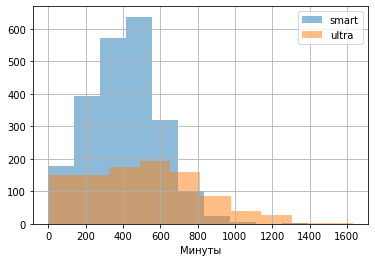

In [65]:
ax = df_smart_v0['minutes'].hist(alpha=0.5)
df_ultra_v0['minutes'].hist(alpha=0.5)
ax.legend(["smart", "ultra"])
ax.set_xlabel('Минуты')

Из гистограмм видно, что смартабоненты чаще говорят "меньше среднего", а вот у минут ультрабонентов разброс более симметричный.

In [66]:
print ('Среднее значение смартминут', df_smart_v0['minutes'].mean().round(2))
print ('Медиана смартминут', df_smart_v0['minutes'].median().round(2))

print ('Среднее значение ультраминут', df_ultra_v0['minutes'].mean().round(2))
print ('Медиана ультраминут', df_ultra_v0['minutes'].median().round(2))

Среднее значение смартминут 405.78
Медиана смартминут 411.0
Среднее значение ультраминут 511.05
Медиана ультраминут 504.0


Исходя из значений среднего и медианы, а также вида гистограмм делаем вывод:
1. Распределение смартминут скошено влево;
2. Распределение ультраминут скошено вправо.

Перейдем к разбросам количества сообщений.

### Сообщения абонентов

Text(0.5, 0, 'Сообщения')

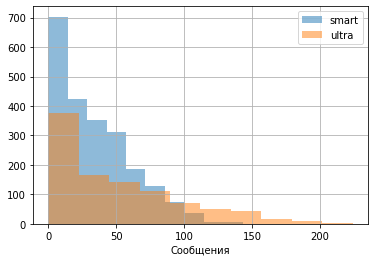

In [67]:
ax = df_smart_v0['messages'].hist(alpha=0.5)
df_ultra_v0['messages'].hist(alpha=0.5)
ax.legend(["smart", "ultra"])
ax.set_xlabel('Сообщения')

Гистограммы отправленных сообщений схожи у обоих тарифов: много данных сосредоточено около нуля.

In [68]:
print ('Среднее значение смартсообщений', df_smart_v0['messages'].mean().round(2))
print ('Медиана смартсообщений', df_smart_v0['messages'].median().round(2))

print ('Среднее значение ультрасообщений', df_ultra_v0['messages'].mean().round(2))
print ('Медиана ультрасообщений', df_ultra_v0['messages'].median().round(2))

Среднее значение смартсообщений 33.38
Медиана смартсообщений 28.0
Среднее значение ультрасообщений 49.36
Медиана ультрасообщений 38.0


Так как медианы меньше средних, то оба распределения скошены вправо.

### Трафик абонентов

Text(0.5, 0, 'Интернет')

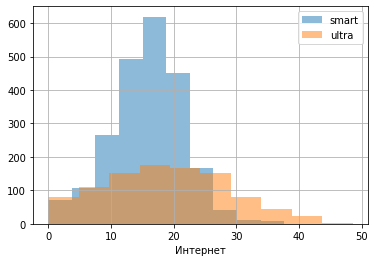

In [69]:
ax = df_smart_v0['gb'].hist(alpha=0.5)
df_ultra_v0['gb'].hist(alpha=0.5)
ax.legend(["smart", "ultra"])
ax.set_xlabel('Интернет')

В отличие от минут и сообщений, интернетом пользуются больше, т.к. большинство данных все-таки не сосредоточены около нуля.

In [70]:
print ('Среднее значение смартгигов', df_smart_v0['gb'].mean().round(2))
print ('Медиана смартгигов', df_smart_v0['gb'].median().round(2))

print ('Среднее значение ультрагигов', df_ultra_v0['gb'].mean().round(2))
print ('Медиана ультрагигов', df_ultra_v0['gb'].median().round(2))

Среднее значение смартгигов 15.83
Медиана смартгигов 16.12
Среднее значение ультрагигов 19.01
Медиана ультрагигов 18.86


Основываясь на гистограммах и вычисленных значениях:

1. Распределение смартгигов скошено влево.
2. Распределение ультрагигов скошено вправо.

## Проверка гипотезы о средней выручке

Рассмотрим выборки выручек пользователей по тарифам.

In [71]:
total_smart = df3.query('tariff == "smart"')['total_pay']
total_ultra = df3.query('tariff == "ultra"')['total_pay']

Text(0.5, 0, 'Выручка')

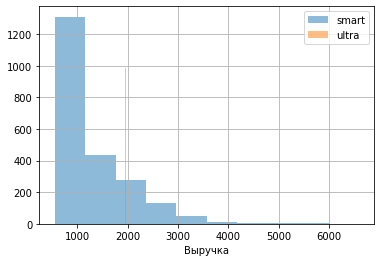

In [72]:
ax = total_smart.hist(alpha=0.5)
total_ultra.hist(alpha=0.5, range=(1900, 2000))
ax.legend(["smart", "ultra"])
ax.set_xlabel('Выручка')

В данном случае мы имеем дело с двумя независимыми выборками количественных данных, подчиняющихся нормальному распределению. Поэтому для проверки гипотез будем использовать критерий Стьюдента.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, используем метод scipy.stats.ttest_ind.
Сформулируем гипотезы:

- Нулевая гипотеза H0: средние выручки пользователей тарифов «Ультра» и «Смарт» равны;

- Альтернативная гипотеза H1: средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

In [73]:
alpha = .05
results = st.ttest_ind(total_smart, total_ultra)

print('p-значение: {:.2f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00
Отвергаем нулевую гипотезу


Таким образом, по имеющимся данным отвергаем гипотезу о том, что средние выручки пользователей разных тарифов равны.

Проведем аналогичную проверку в зависимости от города.

In [74]:
total_msk = df3.query('city == "Москва"')['total_pay']
total_other = df3.query('city != "Москва"')['total_pay']

Text(0.5, 0, 'Выручка')

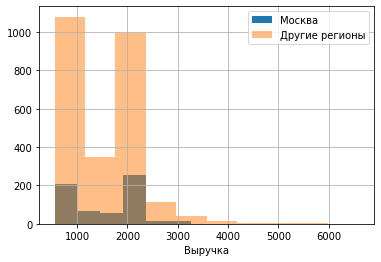

In [75]:
ax = total_msk.hist(alpha=1)
total_other.hist(alpha=0.5)
ax.legend(["Москва", "Другие регионы"])
ax.set_xlabel('Выручка')

В данном случае мы имеем дело с двумя независимыми выборками количественных данных, подчиняющихся нормальному распределению. Поэтому для проверки гипотез будем использовать критерий Стьюдента.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, используем метод scipy.stats.ttest_ind.

- Нулевая гипотеза H0: средние выручки пользователей из Москвы и других регионов равны;

- Альтернативная гипотеза H1: средние выручки пользователей из Москвы и других регионов не равны.

In [76]:
alpha = 0.05
results = st.ttest_ind(total_msk, total_other)

print('p-значение: {:.2f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу


Следовательно, по имеющейся выборке не удалось отвергуть нулевую гипотезу о равенстве средних выручек Москвы и других регионов.

# Общий вывод

Проанализировав данные по абонентам, пользующихся разными тарифами, можем сделать вывод, что несмотря на более высокую цену тарифа "Ультра" бОльшие платежи в 2018 году были совершены абонентами тарифа "Смарт".

Скорее всего это связано с тем, что в тарифе "Ультра" предусмотрены достаточно большие объемы минут, сообщений и трафика в рамках пакета. Абоненты с тарифом "Ультра" выходили за рамки только по дополнительным мегабайтам. При этом абоненты с тарифом "Смарт" пользуются и дополнительными минутами, и дополнительными сообщениями, и дополнительным трафиком.

Также статистический анализ позволил нам отвергнуть гипотезу о равенстве средних выручек абонентов разных тарифов. В то же время гипотезу о равенстве средних выручек Москвы и других регионов отвергнуть не удалось. Для более точно анализа требуются выборки больших размеров, которые будут стремиться к генеральным совокупностям.